# Analyzing ball data

Load needed libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.colors import LogNorm

C:\Users\yannick.gibson\AppData\Local\Temp\ipykernel_23236\3496926915.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load dataset containing predictions on 42min and 54 second video from the dataset "new videos". Change types accordingly.

In [2]:
df = pd.read_csv("ball_positions_42min_120fps.txt", delimiter=";", header=0)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["certainty"] = df["certainty"].astype(float)
df["frame_number"] = df["frame_number"].astype(int)

Check the frame numbers

In [3]:
first_frame_number = df["frame_number"].iloc[0]
last_frame_number = df["frame_number"].iloc[-1]
print(f"First prediction frame number {first_frame_number}, last: {last_frame_number}")

First prediction frame number 0, last: 308344


In [4]:
video_duration_seconds = 42 * 60 + 54
video_frame_rate = 120
print("Aproximate amount of frames:", video_duration_seconds * video_frame_rate)

Aproximate amount of frames: 308880


## Frequency of detections

Let us display a histogram displaying the frequency of detections at timestamps.

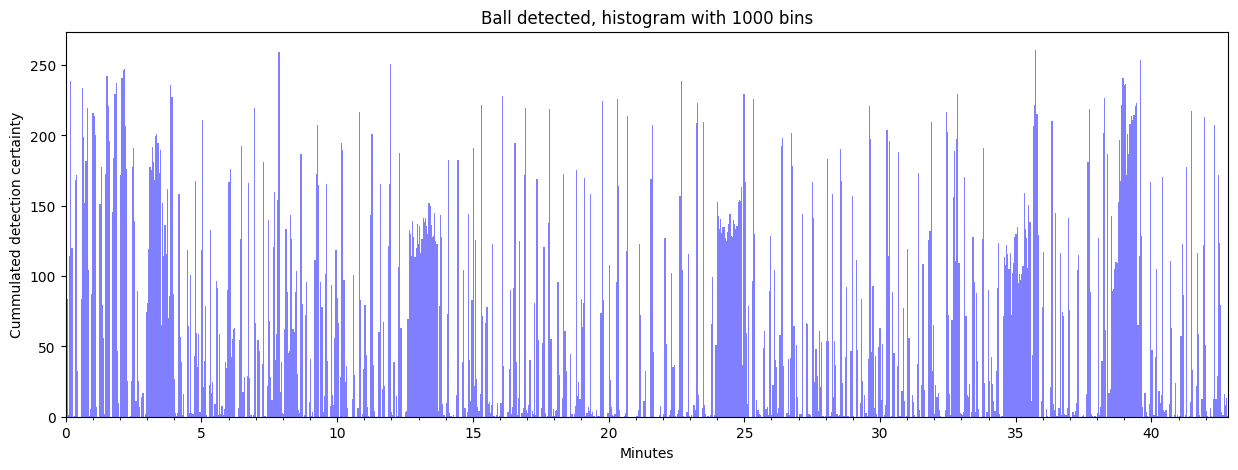

In [5]:
df["time_minutes"] = df["frame_number"] / 120 / 60
bins = 1000
fig = plt.figure()
fig.set_size_inches(15, 5)
ax = fig.add_subplot(111)
ax.set_title(f"Ball detected, histogram with {bins} bins")
ax.set_xlabel("Minutes")
ax.set_ylabel("Cummulated detection certainty")
ax.set_xlim(df["time_minutes"].min(), df["time_minutes"].max())
ax.set_xticks(np.arange(0, 42 + 1), minor=True)

# make a histogram of the ball position hits define 10 bins
ax.hist(df["time_minutes"], weights=df["certainty"], bins=bins, color="blue", alpha=0.5);


We will display the suspicious areas.

C:\Users\yannick.gibson\AppData\Local\Temp\ipykernel_23236\4293357996.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


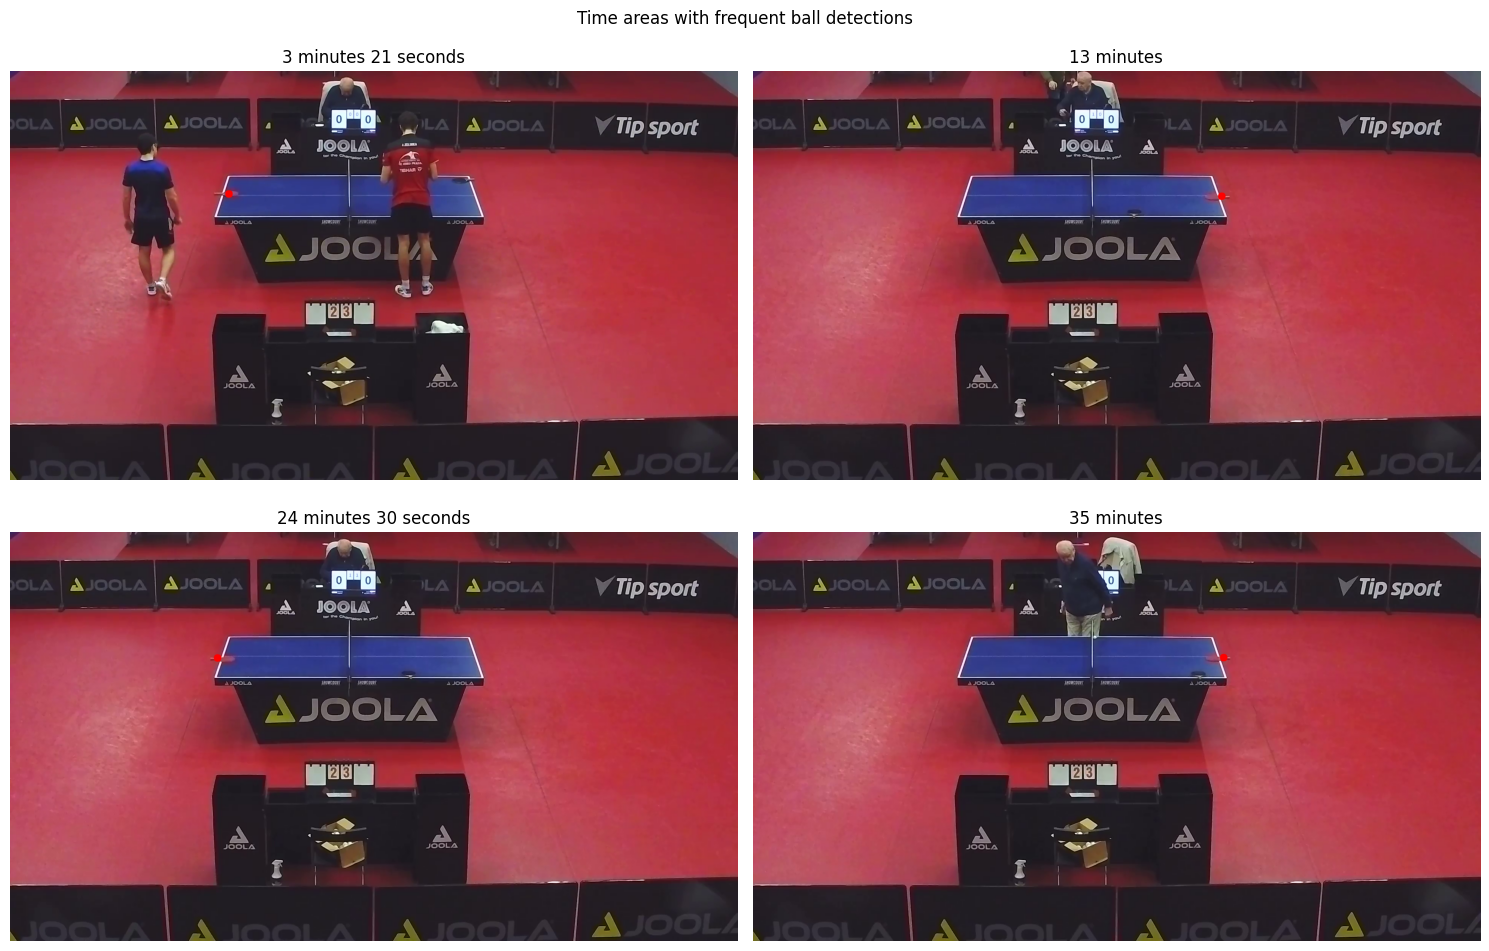

In [6]:
def get_frame_at(minutes, seconds, video_path):
    """
    Get a frame from a video at a specific time.

    Args:
        minutes: minutes of the video
        seconds: seconds of the video
        video_path: video's path

    Returns:
        frame at the specific time in the video
    """
    time_seconds = minutes * 60 + seconds
    frame_number = time_seconds * 120
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    _, frame = cap.read()
    cap.release()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_with_prediction_at(minutes, seconds, video_path, df):
    """
    Get a frame from a video at a specific time with a prediction.

    Args:
        minutes: minutes of the video
        seconds: seconds of the video
        video_path: video's path
        df: dataframe with columns: x, y, frame_number

    Returns:
        _description_
    """
    frame = get_frame_at(minutes, seconds, video_path)
    frame_number = (minutes * 60 + seconds) * 120
    x, y = df[df["frame_number"] == frame_number + 1][["x", "y"]].values[0]
    cv2.circle(frame, (int(x), int(y)), 10, (255, 0, 0), -1)
    return frame

VIDEO_PATH = r"C:\Users\yannick.gibson\projects\school\BP\bachelors_thesis\rod_ping_pong\annotation\mydata\videos\blurred\42min_120fps.mp4"

fig = plt.figure()
axes = fig.subplots(2, 2)
fig.set_size_inches(15, 10)

# plot first subplot
fig.suptitle("Time areas with frequent ball detections")
axes[0, 0].imshow(get_frame_with_prediction_at(3, 21, VIDEO_PATH, df))
axes[0, 0].set_title("3 minutes 21 seconds")
axes[0, 0].axis("off")

# plot second subplot
axes[0, 1].imshow(get_frame_with_prediction_at(13, 0, VIDEO_PATH, df))
axes[0, 1].set_title("13 minutes")
axes[0, 1].axis("off")

# plot third subplot
axes[1, 0].imshow(get_frame_with_prediction_at(24, 30, VIDEO_PATH, df))
axes[1, 0].set_title("24 minutes 30 seconds")
axes[1, 0].axis("off")

# plot fourth subplot
axes[1, 1].imshow(get_frame_with_prediction_at(35, 0, VIDEO_PATH, df))
axes[1, 1].set_title("35 minutes")
axes[1, 1].axis("off")

# make the plots tight
fig.tight_layout()
fig.show();

After looking into the video, we can see that the clusters are actually many false positives. The model thinks a paddle on the table a ball.

## Histogram heatmap
Let us now create a heatmap using a 2d histogram from `numpy.histogram2d`.

In [7]:
overlay_image = plt.imread("42min_overlay.png")

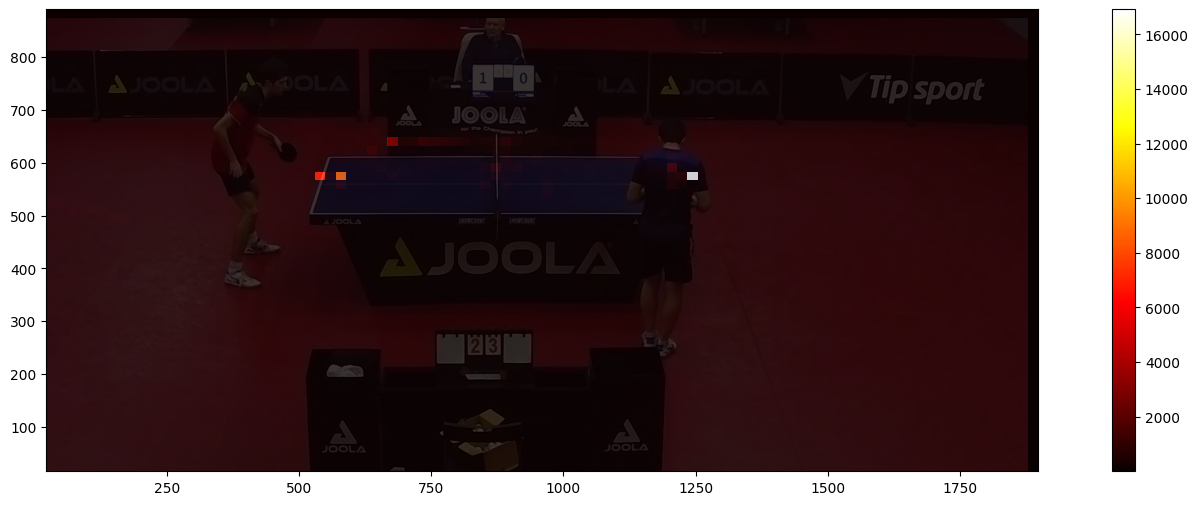

In [31]:
heatmap, xedges, yedges = np.histogram2d(df["x"], df["y"], bins=(16*6, 9*6))
extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig = plt.figure()
fig.set_size_inches(19, 6)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.xlim(xedges[0], xedges[-1])
plt.ylim(yedges[0], yedges[-1])


heatmap[heatmap == 0] = 1  # helps LogNorm to display correctly

plt.imshow(heatmap.T, extent=extent, origin="upper", cmap="hot", norm=LogNorm())
plt.colorbar()
extent_crop = overlay_image[int(yedges[0]): int(yedges[-1]), int(xedges[0]): int(xedges[-1]), :]
plt.imshow(np.flipud(extent_crop), alpha=0.2);


Let us now use a logarithmic scale.

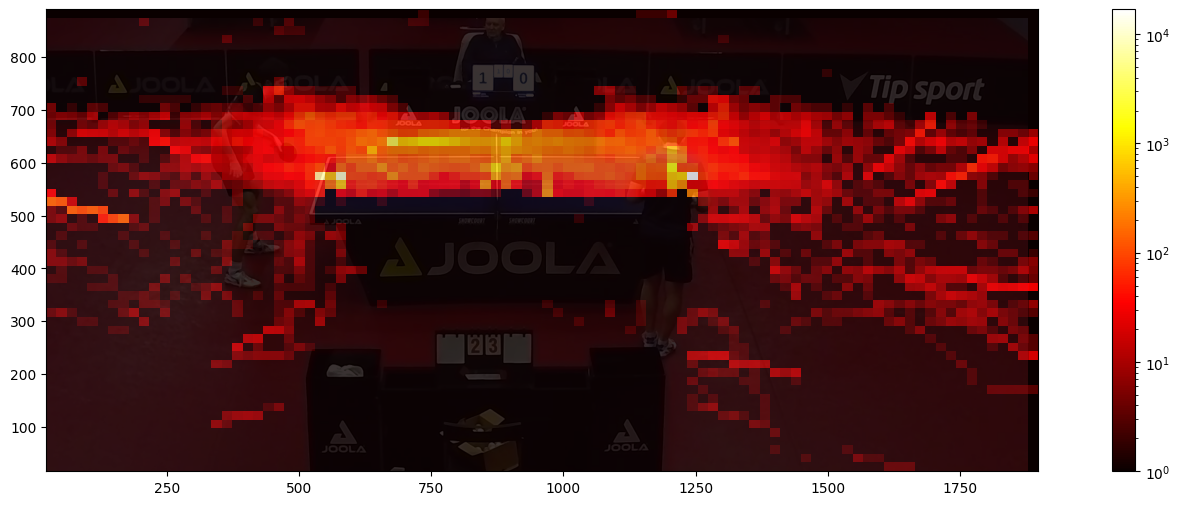

In [33]:
fig = plt.figure()
fig.set_size_inches(19, 6)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.xlim(xedges[0], xedges[-1])
plt.ylim(yedges[0], yedges[-1])

heatmap[heatmap == 0] = 1  # helps LogNorm to display correctly

plt.imshow(heatmap.T, extent=extent, origin="upper", cmap="hot", norm=LogNorm())
plt.colorbar()
plt.imshow(np.flipud(extent_crop), alpha=0.2);


We can see that the model has problems at predicting ball positions at the area where is the scoreboard and the scorekeeper, the ball usually flies to those areas but is not detected.

## Detection areas
We will display the detection areas to see at what positions did we detect a ball. We are going to draw a filled circles using `python-open-cv`.

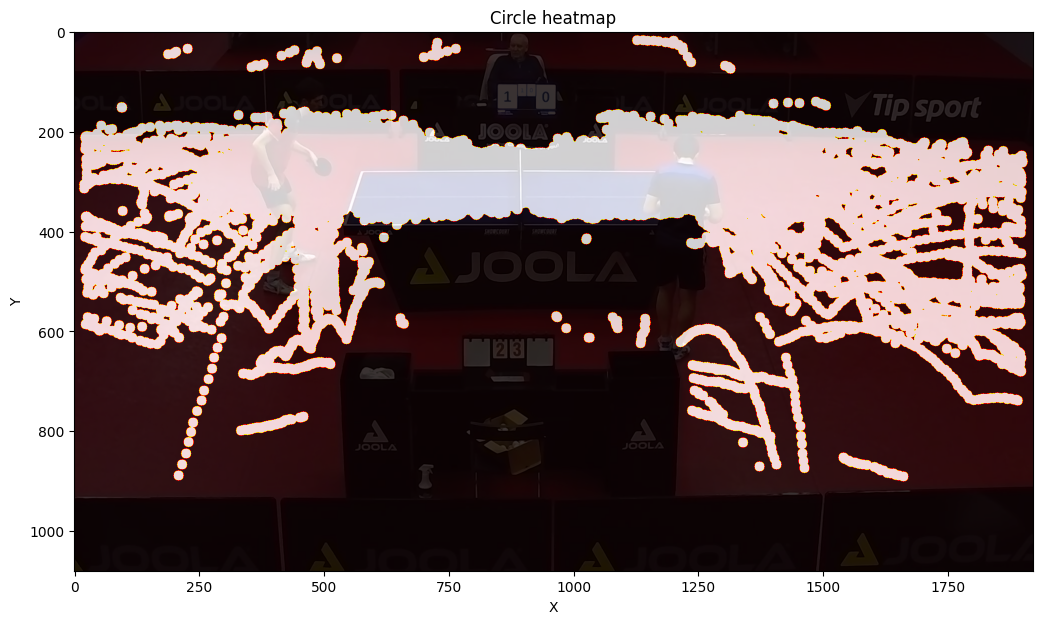

In [9]:
circle_array = np.zeros((1080, 1920), dtype=int)
for index, row in df.iterrows():
    x, y = int(row["x"]), int(row["y"])
    # Overlay a circle
    cv2.circle(circle_array, (int(row["x"]), int(row["y"])), 10, (255, 255, 255), -1)

fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(25, 7)
ax.set_title("Circle heatmap")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.imshow(circle_array, cmap="hot")
ax.imshow(overlay_image, alpha=0.2)
plt.show()

## Heatmap using Gaussian kernel
Now, we will use a Gaussian kernel and weighting using `certainty` value to smoothout the heatmap. Additionally, clip the values of our results so false positives do not overwhelm the heatmap. 

In [10]:
def create_gaussian_kernel(size, sigma=1):
    """
    Create a 2D Gaussian kernel.

    Parameters:
        size (int): Size of the kernel (both width and height).
        sigma (float): Standard deviation of the Gaussian distribution.

    Returns:
        numpy.ndarray: 2D Gaussian kernel.
    """
    # Create a 2D grid of indices centered around the kernel
    x = np.arange(-size // 2 + 1, size // 2 + 1)
    y = np.arange(-size // 2 + 1, size // 2 + 1)
    xx, yy = np.meshgrid(x, y)

    # Calculate the Gaussian kernel using the formula
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)  # Normalize the kernel so that it sums to 1

    return kernel


print(create_gaussian_kernel(5, sigma=2))
print(f"Sum of all units: {create_gaussian_kernel(5, sigma=2).sum()}")

[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]
Sum of all units: 1.0


Let us create a kernel to use in creating the heatmap.

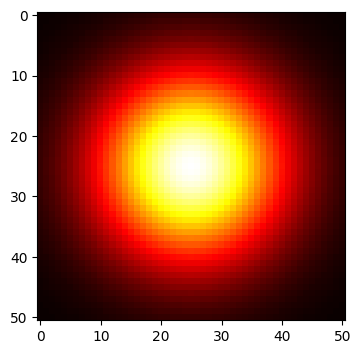

In [11]:
# display this kernel
kernel_size = 51
sigma = 11
gaussian_kernel = create_gaussian_kernel(kernel_size, sigma)
# use matplotlib
fig = plt.figure()
fig.set_size_inches(4, 4)
plt.imshow(gaussian_kernel, cmap="hot");

Create the heatmap and plot the results.

In [51]:
gaussian_array = np.zeros((1080, 1920), dtype=np.float64)

sub = kernel_size // 2
add = kernel_size - sub
for index, row in df.iterrows():
    x, y = int(row["x"]), int(row["y"])
    # Check if the kernel is within the image bounds
    if x-sub >= 0 and x+add <= 1920 and y-sub >= 0 and y+add <= 1080:
        kernel_sum = 255 * row["certainty"]
        gaussian_array[y-sub:y+add, x-sub:x+add] += gaussian_kernel * kernel_sum

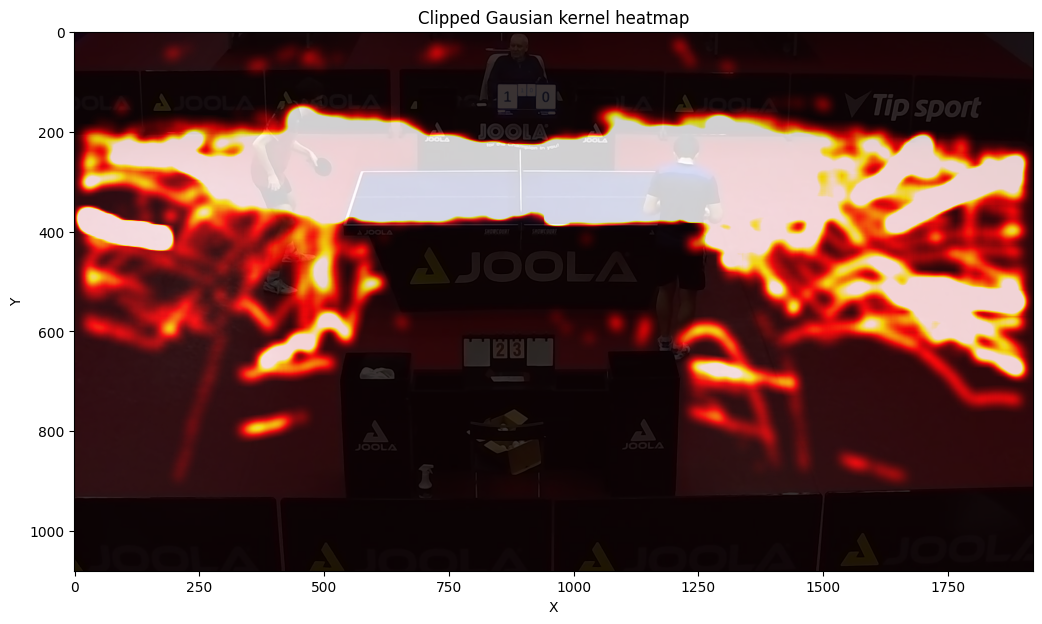

In [79]:

fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(25, 7)
ax.set_title("Clipped Gausian kernel heatmap")
ax.set_xlabel("X")
ax.set_ylabel("Y")
clip_const = 900
norm_gaussian_array = gaussian_array / np.max(gaussian_array) * 255 * clip_const
ax.imshow(np.clip(norm_gaussian_array , 0, 255), cmap="hot")
ax.imshow(overlay_image, alpha=0.2);

plt.show()



We can see that most predictions were on the table area and there were some balls that flew out of the range.

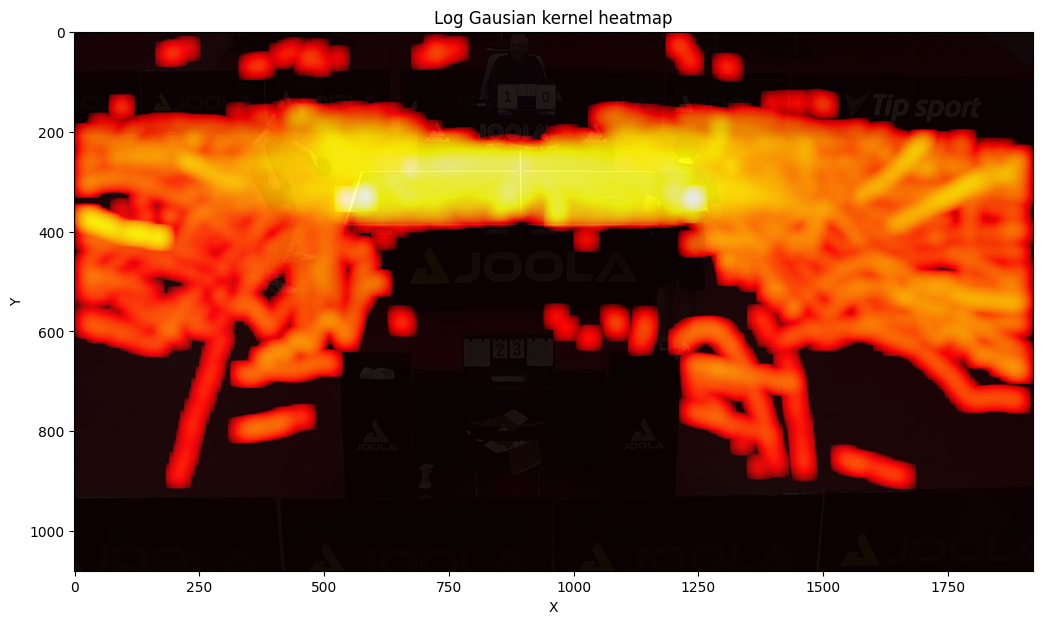

In [78]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(25, 7)
ax.set_title("Log Gausian kernel heatmap")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.imshow(np.ones_like(gaussian_array), cmap="hot", norm=LogNorm())
ax.imshow(gaussian_array, cmap="hot", norm=LogNorm())
ax.imshow(overlay_image, alpha=0.1);

plt.show()


Using logarithmic scale the gaussian kernel is not as smooth but we can see the hot spots on the table where the paddles were located.